Data yang digunakan adalah **"Data Customer Personality Analytics"**

Data diakses pada link berikut -> [GET DATA PLEASE CLICK HERE](https://www.kaggle.com/imakash3011/customer-personality-analysis)

**`Segmentasi Pelanggan pada Sebuah Database Firma Belanja Menggunakan K-Means Clustering`**


# **Input data CSV**

In [ ]:
# Upload file csv untuk segmentasi pelanggan
from google.colab import files
uploaded = files.upload()

Saving marketing_campaign.csv to marketing_campaign.csv


In [ ]:
# import beberapa library yang dibutuhkan
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

In [ ]:
#Memanggil data
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
data.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [ ]:
data.shape

(2240, 29)

# **Data Cleaning**

## (1) Cek missing value

In [ ]:
#Mengecek data yang berisi NaN 
missing_data = data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor (%)']=(data.shape[0]-missing_data['missing values'])/data.shape[0]*100
missing_data.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Income,24,98.928571
1,ID,0,100.000000
2,Z_CostContact,0,100.000000
3,Complain,0,100.000000
4,AcceptedCmp2,0,100.000000
5,AcceptedCmp1,0,100.000000
6,AcceptedCmp5,0,100.000000
7,AcceptedCmp4,0,100.000000
8,AcceptedCmp3,0,100.000000
9,NumWebVisitsMonth,0,100.000000


In [ ]:
#Membuang data NaN
data = data.dropna()

## (2) Ganti Data


In [ ]:
#Menghitung usia pelanggan
data['Age'] = 2021-data['Year_Birth']

#Menjumlah total pengeluaran belanja produk
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

In [ ]:
#Mendefinisikan jumlah penghuni tinggal berdasarkan status perkawinan
data['Living_With'] = data['Marital_Status'].replace({'Married':'Partner','Together':'Partner','Absurd':'Alone','Widow':'Alone','YOLO':'Alone','Divorced':'Alone', 'Single':'Alone'})

In [ ]:
#Memfitur total anak yang tinggal dalam satu rumah
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Memfitur total anggota keluarga dalam satu rumah
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Memfitur kategori orang tua
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

In [ ]:
#Mengelompokkan tingkat pendidikan dalam tiga kelompok
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [ ]:
#Menyederhanakan nama atribut
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Membuang beberapa fitur yang tidak dibutuhkan dalam segmentasi pelanggan
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

## (3) Removing Outlier

In [ ]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,64,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,67,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,56,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,37,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,40,422,Partner,1,3,1


In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,128.000000,2525.000000,3.000000,5.000000,1.000000


In [ ]:
#Menentukan batas maksimum minimum data untuk atribut pendapatan
Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound =  Q3 + 1.5*IQR

#Menentukan batas maksimum minimum data untuk atribut usia
Q11 = data['Age'].quantile(0.25)
Q33 = data['Age'].quantile(0.75)
IQR2 = Q33-Q11
lower_bound2 = Q11 - 1.5*IQR2
upper_bound2 = Q33 + 1.5*IQR2

#Membuang outlier data Pendapatan dan Usia
data = data[(data['Income']<upper_bound)]
data = data[(data['Age']<upper_bound)]
print(len(data))

2208


In [ ]:
data.to_csv("marketing_clean.csv", index = 0)

# **Scaling**

In [ ]:
#Mengambil daftar variabel kategorikal
datatypes = (data.dtypes == 'object')
object_cols = list(datatypes[datatypes].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
#Menggunakan Label Encoder untuk mengubah seluruh tipe data menjadi numerik
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [ ]:
#Membuat salinan dataset
datacopy = data.copy()
#Membuat subdata yang sudah membuang fitur promosi dan transaksi
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
datacopy = datacopy.drop(cols_del, axis=1)
#Penskalaan data
scaler = StandardScaler()
scaler.fit(datacopy)
scaled_datacopy = pd.DataFrame(scaler.transform(datacopy),columns= datacopy.columns )

In [ ]:
#Data yang di-scaling digunakan untuk proses reduksi dimensionalitas
print("Dataframe to be used for further modelling:")
scaled_datacopy.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893308,0.314089,-0.823235,-0.930428,0.310588,0.974689,1.545554,1.747688,2.449620,1.480933,0.846621,0.362555,1.426013,2.628870,-0.561314,0.690245,0.984809,1.678075,-1.346380,-1.266476,-1.758805,-1.584403
1,-0.893308,-0.255431,1.039166,0.907126,-0.380686,-0.874529,-0.638540,-0.731613,-0.652518,-0.635460,-0.735161,-0.167943,-1.132369,-0.587934,-1.178383,-0.138499,1.235034,-0.963323,-1.346380,1.404373,0.449578,0.631152
2,-0.893308,0.964782,-0.823235,-0.930428,-0.795450,0.355320,0.566478,-0.176066,1.336500,-0.148933,-0.040720,-0.698440,1.426013,-0.230512,1.289891,-0.552871,0.317541,0.280959,0.742732,-1.266476,-0.654613,-1.584403
3,-0.893308,-1.206626,1.039166,-0.930428,-0.795450,-0.874529,-0.563226,-0.667335,-0.506535,-0.586807,-0.754451,-0.167943,-0.766886,-0.945357,-0.561314,0.275873,-1.267219,-0.920130,0.742732,0.068949,0.449578,0.631152
4,0.568830,0.321573,1.039166,-0.930428,1.554881,-0.394444,0.415851,-0.217388,0.150388,-0.002975,-0.561551,1.423550,0.329564,0.126911,0.055754,-0.138499,-1.016993,-0.307126,0.742732,0.068949,0.449578,0.631152


# **Clustering**

## (1) PCA

**Principal component analysis** (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

In [ ]:
#Melakukan serangkaian proses reduksi dimensionalitas dataset dengan PCA
pca = PCA(n_components = 2)

In [ ]:
pca.fit(scaled_datacopy)

PCA(n_components=2)

In [ ]:
scores_pca = pca.transform(scaled_datacopy)
print(scores_pca)

[[ 4.98157425 -0.43331642]
 [-2.83904407  0.20260065]
 [ 2.63373565 -0.69713164]
 ...
 [ 2.70161745 -1.79862291]
 [ 1.56062028  1.83461431]
 [-2.77010413  1.53415995]]


## (2) Elbow

Elbow Method to determine the number of clusters to be formed:


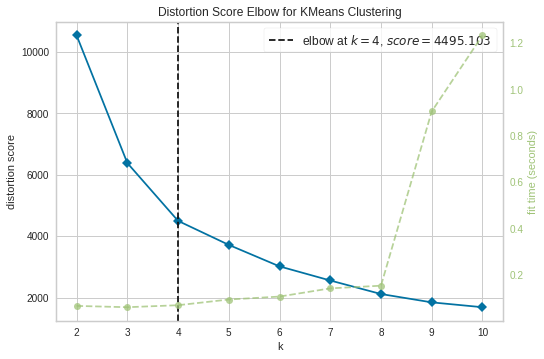

In [ ]:
#Menggunakan Elbow Method untuk menentukan jumlah klaster pada K-Means
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scores_pca)
Elbow_M.show()

## (3) KMeans Clustering


Income terhadap Spending

In [ ]:
#Melakukan klasterisasi dengan menggunakan K-Means Clustering
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [ ]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [ ]:
#Memasukkan komponen PCA yang telah terbentuk ke dalam data
df_segm_pca_kmeans = pd.concat([data.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-2:] = ['Component 1', 'Component 2']
df_segm_pca_kmeans['Segment K-Means PCA'] = kmeans_pca.labels_

df_segm_pca_kmeans.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Component 1,Component 2,Segment K-Means PCA
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,64,1617,0,0,1,0,4.981574,-0.433316,1
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,67,27,0,2,3,1,-2.839044,0.202601,0
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,56,776,1,0,2,0,2.633736,-0.697132,1
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,37,53,1,1,3,1,-2.649728,-1.332109,3
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,40,422,1,1,3,1,-0.618585,0.326580,0


In [ ]:
#Mendefinisikan kluster yang terbentuk
df_segm_pca_kmeans['Cluster'] = df_segm_pca_kmeans['Segment K-Means PCA'].map({0:'1',
                                                                               1:'2',
                                                                               2:'3',
                                                                               3:'4'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


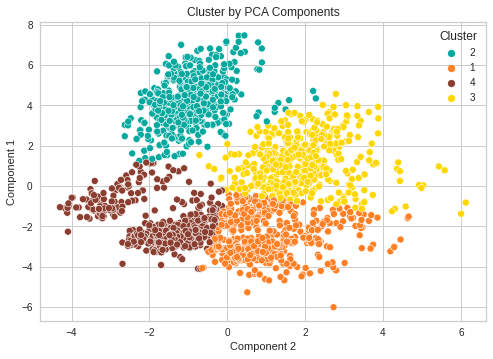

In [ ]:
#Melakukan plotting kluster
x = df_segm_pca_kmeans['Component 2']
y = df_segm_pca_kmeans['Component 1']
plt.figure()
sns.scatterplot(x,y, hue = df_segm_pca_kmeans['Cluster'], palette =["#03A89E","#FF7F24", "#8B3E2F","#FFD700"])
plt.title('Cluster by PCA Components')
plt.show()

Evaluate

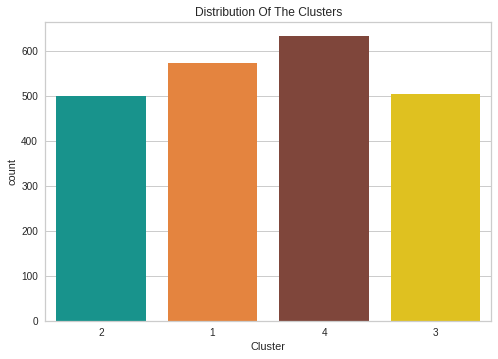

In [ ]:
#Melihat distrbusi jumlah anggota masing-masing kluster
pal = ["#03A89E","#FF7F24", "#8B3E2F","#FFD700"]
pl = sns.countplot(x=df_segm_pca_kmeans['Cluster'], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

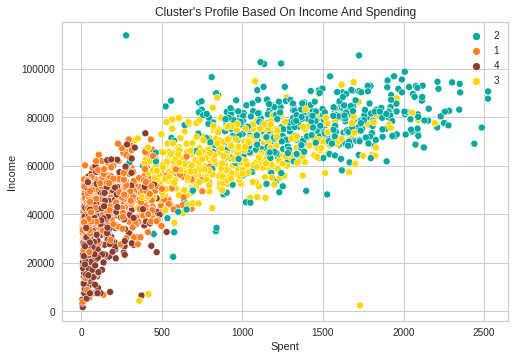

In [ ]:
#Melihat sebaran income terhadap spent dari setiap kluster
pl = sns.scatterplot(x=df_segm_pca_kmeans["Spent"], y=df_segm_pca_kmeans["Income"],hue=df_segm_pca_kmeans["Cluster"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

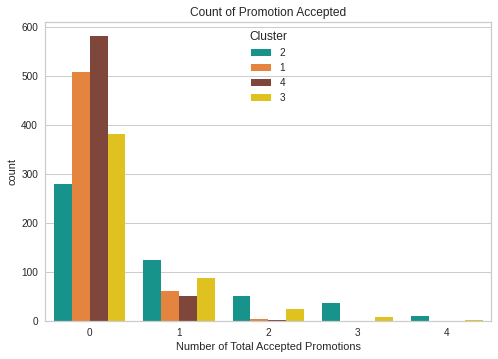

In [ ]:
#Plot jumlah promosi yang diterima
df_segm_pca_kmeans["Total_Promos"] = df_segm_pca_kmeans["AcceptedCmp1"]+ df_segm_pca_kmeans["AcceptedCmp2"]+ df_segm_pca_kmeans["AcceptedCmp3"]+ df_segm_pca_kmeans["AcceptedCmp4"]+ df_segm_pca_kmeans["AcceptedCmp5"]
plt.figure()
pl = sns.countplot(x=df_segm_pca_kmeans["Total_Promos"],hue=df_segm_pca_kmeans["Cluster"], palette= pal)
pl.set_title("Count of Promotion Accepted")
pl.set_xlabel("Number of Total Accepted Promotions")
plt.show()